**TITLE**: Capital asset pricing model with S&P 500 data  
**AUTHOR**: Pablo Carrera Flórez de Quiñones  
**DATE**: May 2020  

# INTRODUCTION

## Statement of the problem

https://en.wikipedia.org/wiki/Capital_asset_pricing_model   
http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-CAPM.pdf  



The S&P 500 is a stock market index that comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges (including the 30 companies that compose the Dow Jones Industrial Average), and covers about 80 percent of the American equity market by capitalization. The index is weighted by free-float market capitalization, so more valuable companies account for relatively more of the index. The index constituents and the constituent weights are updated regularly using rules published by S&P Dow Jones Indices. Although the index is called the S&P 500, the index contains 505 stocks because it includes two share classes of stock from 5 of its component companies. The S&P 500 is maintained by S&P Dow Jones Indices, a joint venture majority-owned by S&P Global and its components are selected by a committee.

In this work, inspired by the *Machine Learning and Reinforcement Learning in Finance Specialization* of *Coursera*, we are going to study a proposal for portfolio optimization based on the construction of eigen-portfolios using Principal Component Analysis (PCA) \[1\]. This will provide a model-free factor analysis, in the sense that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using PCA to deduce structure of portfolio returns.

## References

\[1\] Marco Avellaneda & Jeong-Hyun Lee (2010) *Statistical arbitrage in the US equities market*, Quantitative Finance, 10(7), 761-782, DOI: [10.1080/14697680903124632](https://doi.org/10.1080/14697680903124632)

\[2\] Laurens van der Maaten and Geoffrey Hinton (2008), *Visualizing High-Dimensional Data Using t-SNE*, Journal of Machine Learning Research, 9(Nov), 2579-2605.

## Libraries

In [7]:
# Basics
import pandas as pd
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# DATA

## Importing data

We are going to construct our visualization taking into account the stocks contained into S&P 500 index, which is one of the most followed indicators of the market state. So, the first step in our project is to obtain the data of the daily prices of these stocks. We can obtain this data from Yahoo Finance by running the script *download_stocks_SP500.py* in *utils* folder.

In [8]:
# Import the data after running the script
df = pd.read_csv('data/SP500_stocks_2000_2019.csv', index_col=0, parse_dates=True)

# Show a sample of the data
df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS,^GSPC,VIAC
2000-01-03,47.1875,15.711531,NaN,18.25000,NaN,1.369792,16.390625,15.500,NaN,36.25000,...,63.735176,46.7500,NaN,6.706057,25.027779,NaN,55.5000,NaN,1455.219971,NaN
2000-01-04,45.3125,15.262630,NaN,17.81250,NaN,1.328125,15.015625,14.625,NaN,34.81250,...,60.770752,45.6875,NaN,6.571262,24.666666,NaN,52.8125,NaN,1399.420044,NaN
2000-01-05,46.6250,15.234573,NaN,18.00000,NaN,1.333333,15.312500,15.000,NaN,35.18750,...,63.899868,44.6875,NaN,6.604960,25.138889,NaN,52.7500,NaN,1402.109985,NaN
2000-01-06,50.3750,15.767643,NaN,18.03125,NaN,1.307292,15.437500,16.000,NaN,35.46875,...,62.582344,40.8125,NaN,6.548796,23.777779,NaN,53.5000,NaN,1403.449951,NaN
2000-01-07,51.3750,15.935981,NaN,17.93750,NaN,1.343750,16.187500,16.250,NaN,36.15625,...,64.064560,45.4375,NaN,6.402768,23.513889,NaN,53.6250,NaN,1441.469971,NaN


## EDA

Now, it is always a good idea to look for mising values at the data,

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2000-01-03 to 2019-12-31
Columns: 506 entries, MMM to VIAC
dtypes: float64(506)
memory usage: 19.5 MB


so we can see that some prices have a grear quantity of missing values, this is due to the fact that they became public after the year 2000, so there are no prices below these years. Since we need all time-series to have the same lenght we are going to delete them:

In [10]:
df = df.dropna(axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2000-01-03 to 2019-12-31
Columns: 364 entries, MMM to ^GSPC
dtypes: float64(364)
memory usage: 14.0 MB


And now, we can plot the historical evolution of the prices

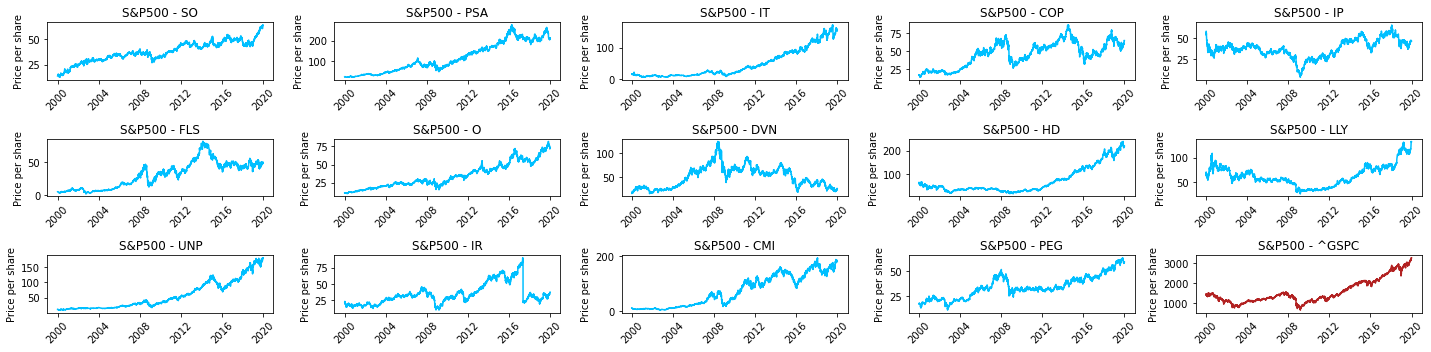

In [11]:
# Select some stocks to plot
random.seed(0)
stocks_to_plot = random.choices(df.columns.to_list()[:-1], k=14) + ['^GSPC']

# Make the layout
n_rows = 3
n_cols = 5

fig = plt.figure(figsize = (20,5))
for i, stock in enumerate(stocks_to_plot):
    # Choose the color
    if stock == '^GSPC':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x=df.index, y=df[stock], color=color)

    # Formatting
    plt.title('S&P500 - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Price per share')
    plt.xticks(rotation=45)

# Formatting
plt.tight_layout()
plt.show()

# MODELLING

## Computation of returns

It is a common practice not to analize the price series itself, but its retuns. The returns are computed as the porcentual change in the price series, that is, if the price for an asset $i$ at time $t$ is given by $p_i^{t}$ then its return will be given by

$$ r_i^t = \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

and it is also common to compute the log-returns, which are simply a logarithmic version of these returns

$$ r_i^{'t} = \log \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

which provide a smoother representation of the series.

Since some stocks are more volatile than others, it is convenient to work with standardized returns, that is, to substract the mean $\mu_i$ of each return and divide the residual by the return's standard deviation $\sigma_i$, given by

\begin{align*}
    & \mu_i = \frac{1}{T} \sum_{t=1}^T r_i^t \\
    & \sigma_i^2 = \frac{1}{T-1} \sum_{t=1}^T (r_i^t - \mu_i)^2 \ 
\end{align*}

so we get

$$ r_i^t = \frac{r_i^t - \mu_i}{\sigma_i} $$

In [12]:
# Compute the returns
df_returns = df.pct_change().dropna(axis=0)

# Standarize the returns
df_mean = df_returns.mean(axis=0)
df_volatility = df_returns.std(axis=0)
df_stand = (df_returns - df_mean) / df_volatility

And visualizing the returns

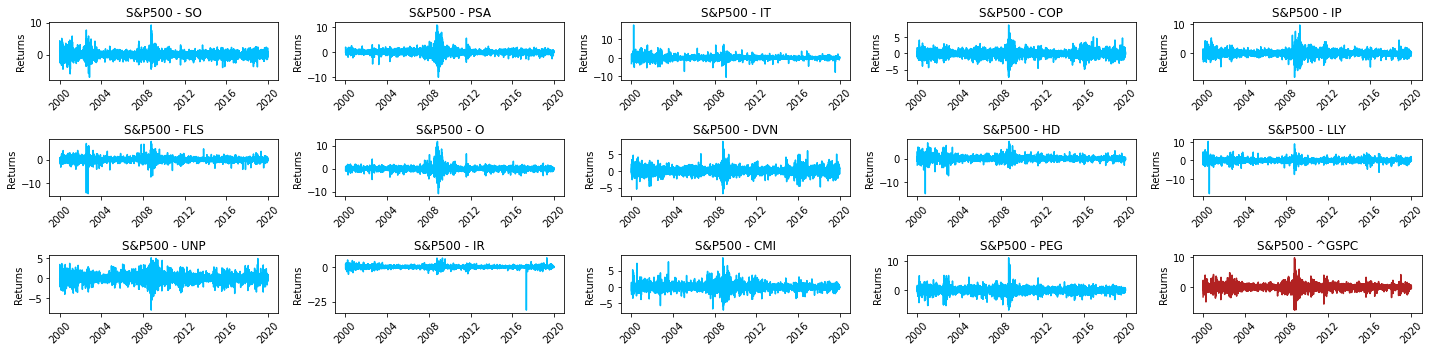

In [13]:
# Make the layout
n_rows = 3
n_cols = 5

plt.figure(figsize=(20,5))
for i, stock in enumerate(stocks_to_plot):
    # Choose the color
    if stock == '^GSPC':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x=df_stand.index, y=df_stand[stock], color=color)

    # Formatting
    plt.title('S&P500 - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Returns')
    plt.xticks(rotation=45)

# Formatting
plt.tight_layout()
plt.show()

## Returns regression on S&P 500 Index

In the previous visualizations we can see some resemblance between the stock prices/returns and the S&P 500 prices/returns. In this section we are going to explore this. We start by ploting the stock prices against the market index

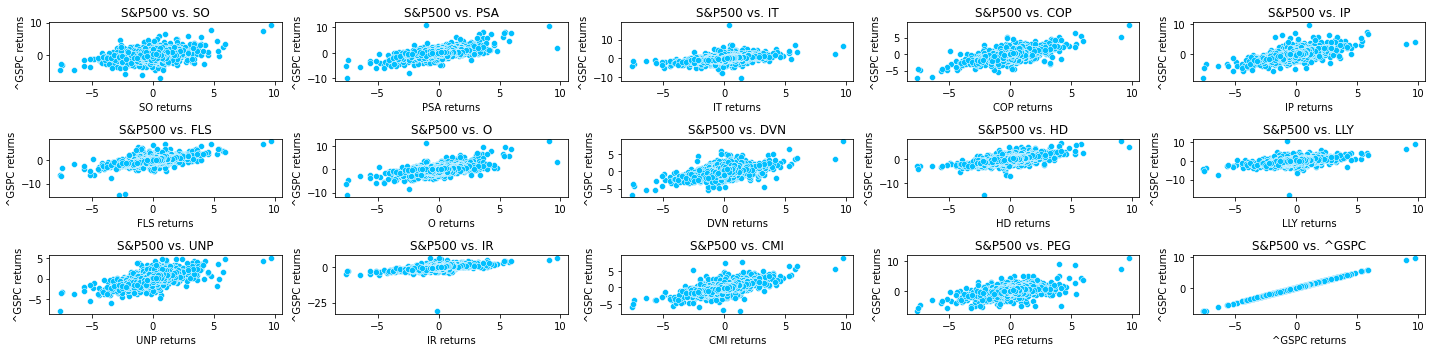

In [14]:
# Make the layout
n_rows = 3
n_cols = 5

plt.figure(figsize=(20,5))
for i, stock in enumerate(stocks_to_plot):
    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=df_stand['^GSPC'], y=df_stand[stock], color='deepskyblue')

    # Formatting
    plt.title('S&P500 vs. {}'.format(stock))
    plt.xlabel('{} returns'.format(stock))
    plt.ylabel('^GSPC returns')

# Formatting
plt.tight_layout()
plt.show()

where we can see that they are related in a linear fashion.

Now, we can think about building a model for the returns of the stocks into the index. One possible model is a simple linear regression of the returns $r_i$ into a single predictor $r_M$ usuall called the market factor, and represented by a market index, such as S&P 500 in our case.

$$ r_i (t) = \alpha_i + \beta_i r_M(t) + \varepsilon $$

In [15]:
# Obtain a test set and a training set
X = df_returns[['^GSPC']]
y = df_returns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize the table for the results
df_regression = pd.DataFrame(columns=['Stock','Alpha','Beta','R2_train','R2_test'])

# Compute the models
for i, stock in enumerate(df_returns.columns.tolist()):
    # Create and train the model
    lr = LinearRegression()
    lr.fit(X_train,y_train[[stock]])

    # Save the details of the model
    df_regression = df_regression.append({'Stock'    : stock,
                                          'Alpha'    : lr.intercept_[0],
                                          'Beta'     : lr.coef_[0][0],
                                          'R2_train' : lr.score(X_train,y_train[[stock]]),
                                          'R2_test'  : lr.score(X_test,y_test[[stock]])
                                           },  
                                           ignore_index=True)

# Show a sample of the results
df_regression.head()

,Stock,Alpha,Beta,R2_train,R2_test
0,MMM,0.000254,0.840970,0.463012,0.475403
1,ABT,0.000473,0.575420,0.209762,0.279314
2,ABMD,0.000683,1.194710,0.147338,0.126496
3,ATVI,0.000799,1.068311,0.209853,0.194450
4,ADBE,0.000652,1.432402,0.370955,0.319668


and plotting these lines

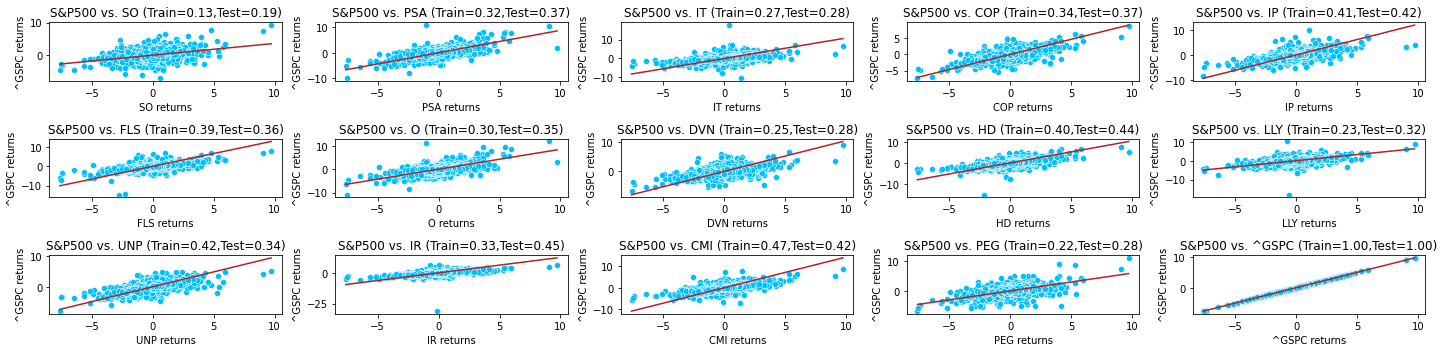

In [16]:
# Make the layout
n_rows = 3
n_cols = 5

plt.figure(figsize=(20,5))
for i, stock in enumerate(stocks_to_plot):
    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=df_stand['^GSPC'], y=df_stand[stock], color='deepskyblue')

    # Add the line
    alpha    = df_regression.loc[df_regression['Stock'] == stock, 'Alpha'].values[0]
    beta     = df_regression.loc[df_regression['Stock'] == stock, 'Beta'].values[0]
    r2_train = df_regression.loc[df_regression['Stock'] == stock, 'R2_train'].values[0]
    r2_test  = df_regression.loc[df_regression['Stock'] == stock, 'R2_test'].values[0]

    sns.lineplot(x=df_stand['^GSPC'], y=alpha + beta * df_stand['^GSPC'], color='firebrick')

    # Formatting
    plt.title('S&P500 vs. {} (Train={:.2f},Test={:.2f})'.format(stock, r2_train, r2_test))
    plt.xlabel('{} returns'.format(stock))
    plt.ylabel('^GSPC returns')

# Formatting
plt.tight_layout()
plt.show()

where we can see that the trend is well captured, but not the variance, as shows the $R^2$ coefficient.

## Computation of unexplained variance

This analysis leads naturally to a study of the deviations of the stocks froms the market, which can be computed as

$$ \varepsilon_i (t) = r_i (t) - [ \alpha_i + \beta_i r_M(t) ] $$

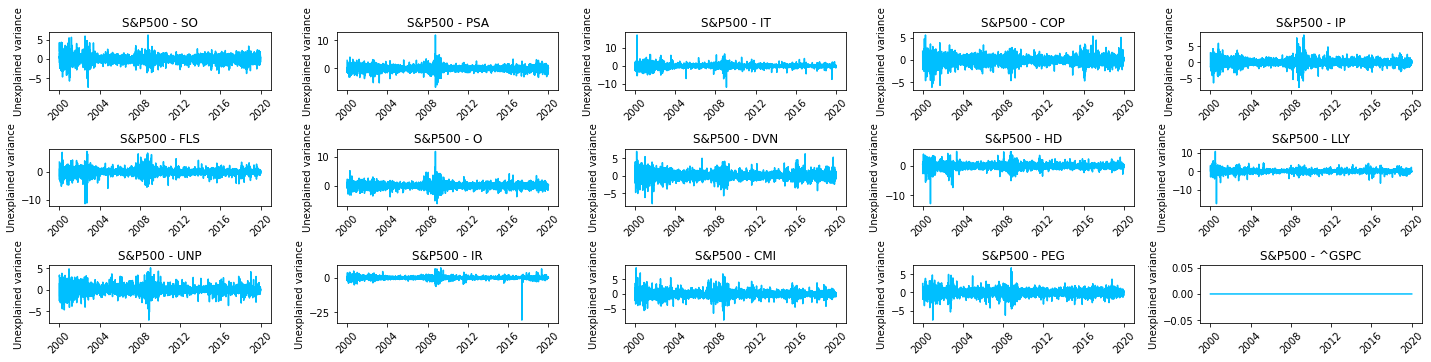

In [18]:
# Initialize the dataframe
df_unexplained = df_stand.copy()

# Compute the unnexplained variance for each stock
for i, stock in enumerate(df_stand.columns.to_list()):
    # Get the paramters
    alpha = df_regression.loc[df_regression['Stock'] == stock, 'Alpha'].values[0]
    beta  = df_regression.loc[df_regression['Stock'] == stock, 'Beta'].values[0]

    # Substract the market
    df_unexplained[stock] = df_stand[stock] - alpha - beta * df_stand['^GSPC']

# Make the layout
n_rows = 3
n_cols = 5

plt.figure(figsize=(20,5))
for i,stock in enumerate(stocks_to_plot):
    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x=df_unexplained.index, y=df_unexplained[stock], color='deepskyblue')

    # Formatting
    plt.title('S&P500 - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Unexplained variance')
    plt.xticks(rotation=45)

# Formatting
plt.tight_layout()
plt.show()